In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os
import ali.methods
import ali.ui

In [2]:
# for id in os.listdir('output/my'):
#         if not "P" in id :continue
        
#         hr,step,rhr,info=ali.methods.load(id)
#         if info['covid_test_date']:
#             print(f'{id}')
# #             break
        
# #         alarms = pd.read_csv(f'output/my/{id}/alarm.csv',parse_dates=['datetime'],index_col='datetime').fillna(0)
# #         alarms['datetime'] = pd.to_datetime(alarms['datetime'])
# #         alarms = alarms.set_index('datetime')
# #         if not os.path.isfile(f'output/my/{id}/rhr.h5'):
# #             continue
        
# #         rhr = pd.read_hdf(f'output/my/{id}/rhr.h5', 'rhr',mode='r')
        
# #         display(rhr)



{'id': 'P476443', 'device': 'Fitbit', 'covid_test_date': Timestamp('2027-10-24 00:00:00'), 'symptom_date': Timestamp('2027-10-21 00:00:00')}


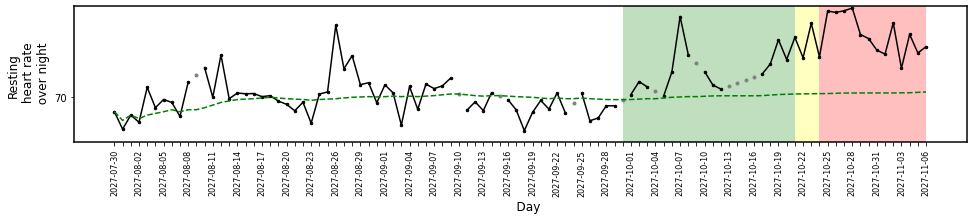

In [3]:
id='P476443'
seg='1T'
import pandas as pd

import ali.methods
import ali.ui
hr,step,rhr,info=ali.methods.load(id)
print(info)
ali.ui.plot(rhr,alerts=pd.DataFrame(),info=info,show=True)
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import json
import os
import compress_pickle
from sklearn.preprocessing import StandardScaler


def selectTrainTestSet(rhr, info,train_days=100,test_days=14):
#     train=rhr.loc[(rhr.index < info['covid_test_date']- pd.to_timedelta(f'{test_days}d'))]
#     test=rhr.loc[(rhr.index >= info['covid_test_date']- pd.to_timedelta(f'{test_days}d'))]
#     return train,test
    if info['covid_test_date']:
        dates_s = rhr.loc[(rhr.index < info['covid_test_date'] - pd.to_timedelta(f'{test_days}d'))].index.floor('1D').unique()
        dates_e = list(rhr.loc[(rhr.index > info['covid_test_date'] + pd.to_timedelta(f'{test_days}d'))].index.floor('1D').unique())
    else:
        dates_s = rhr.index.floor('1D').unique()
        dates_e = []
        
    dates_e.append(rhr.index[-1])

    s = min(train_days, len(dates_s)-1)
    e = -min(max(0,train_days-s), len(dates_e)-1)
#     print(s)
#     print(dates_s)
#     print(e)
#     print(dates_e)
    train = rhr.loc[(rhr.index < dates_s[s]) | (rhr.index > dates_e[e])]
    test = rhr.loc[(rhr.index >= dates_s[s]) & (rhr.index <= dates_e[e])]

    return train, test


def preprocessing(train, test):
    # display(rhr)

    if os.path.isfile(f'ali/an_data/preprocess.pkl.lz41'):
        scaler = compress_pickle.load(f'ali/an_data/preprocess.pkl.lz4')
    else:
        scaler = StandardScaler()
        scaler = scaler.fit(train[['heartrate']])
        compress_pickle.dump(scaler, f'ali/an_data/preprocess.pkl.lz4')

    train = pd.DataFrame(scaler.transform(train),index=train.index,columns=train.columns)
    test = pd.DataFrame(scaler.transform(test),index=test.index,columns=test.columns)
    return train, test

# def preprocessing(train, test):
#     training_mean = train.mean()
#     training_std = train.std()
#     train = (train - training_mean) / training_std
#     test = (test - training_mean) / training_std
#     return train,test

def create_sequences(data, resolution, seg):
#     data = data.resample(resolution).mean().dropna()
    dates = data.loc[data.index.hour < 7].dropna().resample('1D').count()
    min_acceptable_count = dates.loc[dates['heartrate'] > 0].mean().values[0]/4
    data['date'] = data.index.floor('1D')
    data['time'] = data.index.time
    day_time = data.set_index(['time', 'date']).unstack(level=0).droplevel(0, axis=1).interpolate(limit_direction='both', axis=1)
    out=[]
    for w in dates.rolling(window=f'{seg}D', closed='right'):
        if len(w)==seg :#and w.sum().values[0]>min_acceptable_count*seg:
            res = day_time.reindex(w.index).interpolate(limit_direction='both', axis=0).values
            out.append(np.reshape(res, (res.shape[0]*res.shape[1],1)))
#             out.append(res)
        
    return np.stack(out)

def create_sequences(data,resolution, seg):
    time_steps=int(pd.to_timedelta('7h')/pd.to_timedelta(resolution)*seg)
    data = data.resample(resolution).mean().dropna()
#     data=data.loc[data.index.hour<7]
    values=data.values
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


def createAutoEncoderModel(shape):
    model = keras.Sequential(
        [
            layers.Input(shape=(shape[1], shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    return model


def createLSTMModel(shape):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=4,
        input_shape=(shape[1], shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=shape[1]))
    model.add(keras.layers.LSTM(units=4, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(
        keras.layers.TimeDistributed(
            keras.layers.Dense(units=shape[2])
        )
    )
    model.compile(loss='mae', optimizer='adam')
    return model


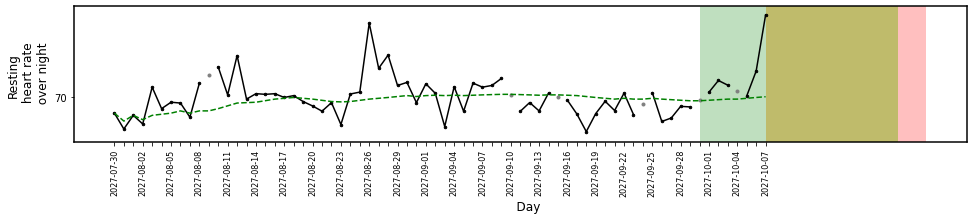

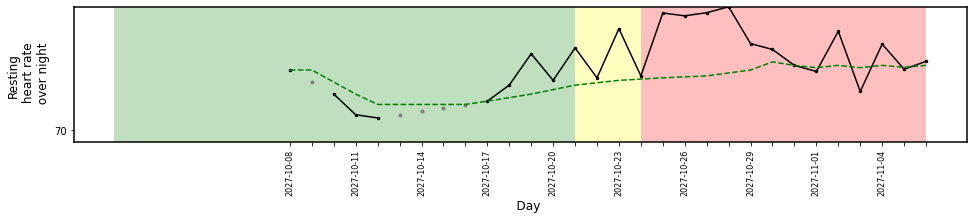

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 256)            1536      
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2956/2956 [==============================] - 3s 795us/step - loss: 40.4984 - mean_absolute_error: 0.9287 - val_loss: 0.0052 - val_mean_absolute_error: 0.0478
Epoch 2/100
2956/2956 [==============================] - 2s 721us/step - loss

2956/2956 [==============================] - 2s 734us/step - loss: 0.0012 - mean_absolute_error: 0.0156 - val_loss: 4.0284e-06 - val_mean_absolute_error: 0.0019
Epoch 44/100
2956/2956 [==============================] - 2s 755us/step - loss: 0.0011 - mean_absolute_error: 0.0154 - val_loss: 3.6223e-06 - val_mean_absolute_error: 0.0019
Epoch 45/100
2956/2956 [==============================] - 2s 746us/step - loss: 0.0013 - mean_absolute_error: 0.0156 - val_loss: 3.6088e-05 - val_mean_absolute_error: 0.0057
Epoch 46/100
2956/2956 [==============================] - 2s 744us/step - loss: 0.0013 - mean_absolute_error: 0.0158 - val_loss: 7.8564e-06 - val_mean_absolute_error: 0.0027
Epoch 47/100
2956/2956 [==============================] - 2s 729us/step - loss: 0.0011 - mean_absolute_error: 0.0145 - val_loss: 7.3767e-08 - val_mean_absolute_error: 2.0215e-04
Epoch 48/100
2956/2956 [==============================] - 2s 727us/step - loss: 0.0012 - mean_absolute_error: 0.0149 - val_loss: 2.2853e-07

2956/2956 [==============================] - 2s 758us/step - loss: 0.0012 - mean_absolute_error: 0.0127 - val_loss: 1.2530e-07 - val_mean_absolute_error: 3.3858e-04
Epoch 91/100
2956/2956 [==============================] - 2s 804us/step - loss: 0.0011 - mean_absolute_error: 0.0159 - val_loss: 2.3934e-04 - val_mean_absolute_error: 0.0153
Epoch 92/100
2956/2956 [==============================] - 2s 788us/step - loss: 0.0012 - mean_absolute_error: 0.0150 - val_loss: 0.0025 - val_mean_absolute_error: 0.0493
Epoch 93/100
2956/2956 [==============================] - 2s 771us/step - loss: 0.0011 - mean_absolute_error: 0.0166 - val_loss: 5.4647e-08 - val_mean_absolute_error: 2.1654e-04
Epoch 94/100
2956/2956 [==============================] - 2s 720us/step - loss: 9.8568e-04 - mean_absolute_error: 0.0178 - val_loss: 2.3296e-05 - val_mean_absolute_error: 0.0048
Epoch 95/100
2956/2956 [==============================] - 2s 736us/step - loss: 0.0011 - mean_absolute_error: 0.0158 - val_loss: 1.1146

In [4]:
model='auto-encoder'; resolution='1T'; seg=3
model='lstm';
rhr1=rhr.resample(resolution).mean().dropna()
train, test = selectTrainTestSet(rhr1, info,train_days=100)
ali.ui.plot(train,alerts=pd.DataFrame(),info=info,show=True)
ali.ui.plot(test,alerts=pd.DataFrame(),info=info,show=True)
trainp, testp = preprocessing(train, test)

x_train = create_sequences(trainp, resolution, seg)

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras_anomaly_detection.library.plot_utils import visualize_reconstruction_error
from keras_anomaly_detection.library.recurrent import LstmAutoEncoder
from keras_anomaly_detection.library.convolutional import Conv1DAutoEncoder
ae = Conv1DAutoEncoder()
ae.fit(train, model_dir_path='/workspace/COVID/keras-anomaly-detection/demo/ecg_demo/models', estimated_negative_sample_ratio=0.99)
anomaly_information = ae.anomaly(test)

In [5]:
anomaly_information = ae.anomaly(test)

In [6]:
anomalies=[i for i,(b,p) in enumerate(anomaly_information) if b]
anomalies

[626,
 627,
 816,
 819,
 965,
 1244,
 1248,
 1303,
 1331,
 1539,
 1698,
 1825,
 1878,
 2044,
 2045,
 2046,
 2047,
 2048,
 2049,
 2050,
 2051,
 2052,
 2053,
 2054,
 2055,
 2056,
 2091,
 2137,
 2138,
 2141,
 2142,
 2145,
 2149,
 2153,
 2171,
 2298,
 2318,
 2319,
 2437,
 2678,
 2731,
 2774,
 2799,
 2869,
 2870,
 2871,
 2872,
 2873,
 2874,
 2875,
 2876,
 2877,
 2878,
 2879,
 2880,
 2881,
 2882,
 2883,
 2964,
 2975,
 3054,
 3074,
 3138,
 3254,
 3312,
 3314,
 3315,
 3316,
 3317,
 3319,
 3320,
 3321,
 3322,
 3323,
 3324,
 3325,
 3326,
 3327,
 3328,
 3329,
 3330,
 3331,
 3332,
 3333,
 3334,
 3335,
 3336,
 3337,
 3338,
 3339,
 3340,
 3341,
 3342,
 3349,
 3356,
 3358,
 3365,
 3375,
 3402,
 3414,
 3427,
 3445,
 3455,
 3457,
 3478,
 3483,
 3500,
 3524,
 3540,
 3651,
 3729,
 3949,
 3951,
 3997,
 4086,
 4202,
 4274,
 4276,
 4288,
 4377,
 4390,
 4391,
 4396,
 4450,
 4465,
 4479,
 4488,
 4519,
 4521,
 4806,
 4890,
 4941,
 4946,
 4949,
 4951,
 4952,
 4953,
 4954,
 4955,
 4956,
 4957,
 4958,
 4959,
 496

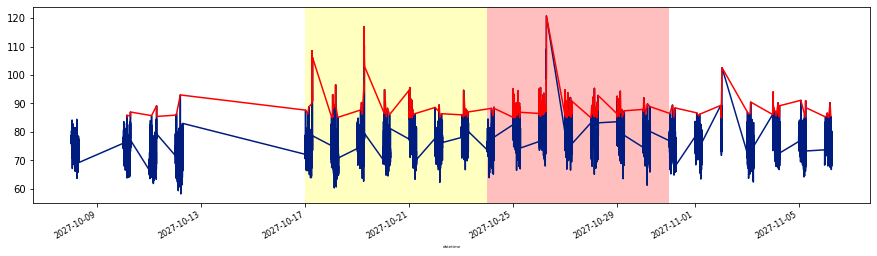

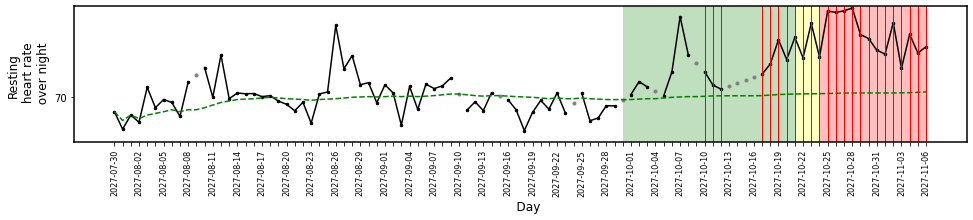

                     heartrate
datetime                      
2027-10-08 00:00:00  80.166667
2027-10-08 00:01:00  77.600000
2027-10-08 00:02:00  77.166667
2027-10-08 00:03:00  75.857143
2027-10-08 00:04:00  76.428571
...                        ...
2027-10-08 06:39:00  71.000000
2027-10-08 06:40:00  72.333333
2027-10-08 06:41:00  74.727273
2027-10-08 06:42:00  78.444444
2027-10-08 06:43:00  74.545455

[402 rows x 1 columns]


In [7]:
df_subset = test.iloc[anomalies]
fig, ax = plt.subplots()
fig.set_figwidth(15)

test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")

if(info['covid_test_date']!=None):
        plt.axvspan(info['covid_test_date'], min(test.index[-1], info['covid_test_date']+pd.to_timedelta('7d')), facecolor='red', alpha=0.25, label='Covid')
        plt.axvspan(info['covid_test_date'], max(test.index[1], info['covid_test_date']-pd.to_timedelta('7d')), facecolor='yellow', alpha=0.25, label='Covid')
plt.show()



dates = df_subset.resample('1D').count().fillna(0).rename(columns={'heartrate': 'count'})

dates['alarm'] = (dates['count'] > 0)*2
# return dates
ali.ui.plot(rhr,alerts=dates,info=info,show=True)
print(test.iloc[np.where(anomalies)])